# Activity 4.1. EM for GMM
In this activity we practice Hard and Soft Expectation Maximimization to train Gaussian Mixture Models.

## Libraries
In this activity we need to use some special packages to generate synthetic data and sample from gaussian mixture models. In particular, we use `mvtnorm` for generating  multivariate Gaussian sampels and `clusterGeneration` for generating covariance matrices. 

In [1]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_Australia.1252  LC_CTYPE=English_Australia.1252   
[3] LC_MONETARY=English_Australia.1252 LC_NUMERIC=C                      
[5] LC_TIME=English_Australia.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_3.5.1  IRdisplay_0.5.0 pbdZMQ_0.3-3    tools_3.5.1    
 [5] htmltools_0.3.6 base64enc_0.1-3 crayon_1.3.4    Rcpp_1.0.1     
 [9] uuid_0.1-2      IRkernel_0.8.12 jsonlite_1.6    digest_0.6.18  
[13] repr_0.15.0     evaluate_0.13  

In [2]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          5.1                         
year           2018                        
month          07                          
day            02                          
svn rev        74947                       
language       R                           
version.string R version 3.5.1 (2018-07-02)
nickname       Feather Spray               

In [3]:
options(warn=-1)
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(clusterGeneration) # generates the covariance matrices that we need for producing synthetic data.

Loading required package: MASS


## Synthetic Data Generation
In this part we mix samples from a few Gaussian distribution to produce Gaussian mixtures. In the next steps we try to train a mixture model based on these samples.

Let's start with setting the main parameters...

In [4]:
# Set the parameters:
set.seed(12345) # save the random seed to make the results reproducble
N <- 1000 # number of samples
K <- 3    # number of clusters
D <- 2    # number of dimensions

... and then initiating the matrices

In [5]:
# Initializations:
Phi <- runif(K); Phi <- Phi/sum(Phi)    # Phi(k) indicates the fraction of samples that are from cluster k
Nk <- matrix(0,nrow = K)    # initiate  the effective number of points assigned to each cluster
Mu <- matrix(runif(K*D, min=-1)*10,nrow = K, ncol = D)    # initiate the centriods (means) of the clusters (randomly chosen)
Sigma <- matrix(0,nrow = K, ncol = D^2)    # initiate the covariance matrix

Now, we can easily create covariance matrices

In [6]:
# Create the covariance matrices:
for (k in 1:K){
    # For each cluster generate one sigma matrix
    Sigma[k,] <- genPositiveDefMat(D)$Sigma[1:D^2]
}

OK! Now we ready to generate our synthetic data. Note that we should remove the labels as the EM algorithm should be able to cluster the points without knowing the real cluster labels.

In [7]:
# Generate data:
data <- data.frame(K=integer(), X1=double(), X2=double()) # empty dataset
data[1:N,'K'] <- sample(1:K, N, replace = TRUE, prob = Phi) # generate labels (they will not be used in EM, just for validation)
## For each cluster k:
for (k in 1:K){
    ### calculate the effective number of points assigned to it:
    Nk[k] <- sum(data$K==k)
    ### generate the actual points:
    data[data$K==k, 2:3] <- rmvnorm(n = Nk[k], Mu[k,], matrix(Sigma[k,], ncol=D))
}

# Remove the labels! So, our GMM has no clue what are the real labels.
X <- as.matrix(data[,-1]) 

To finish this part, let's take a quick look at the generated data.

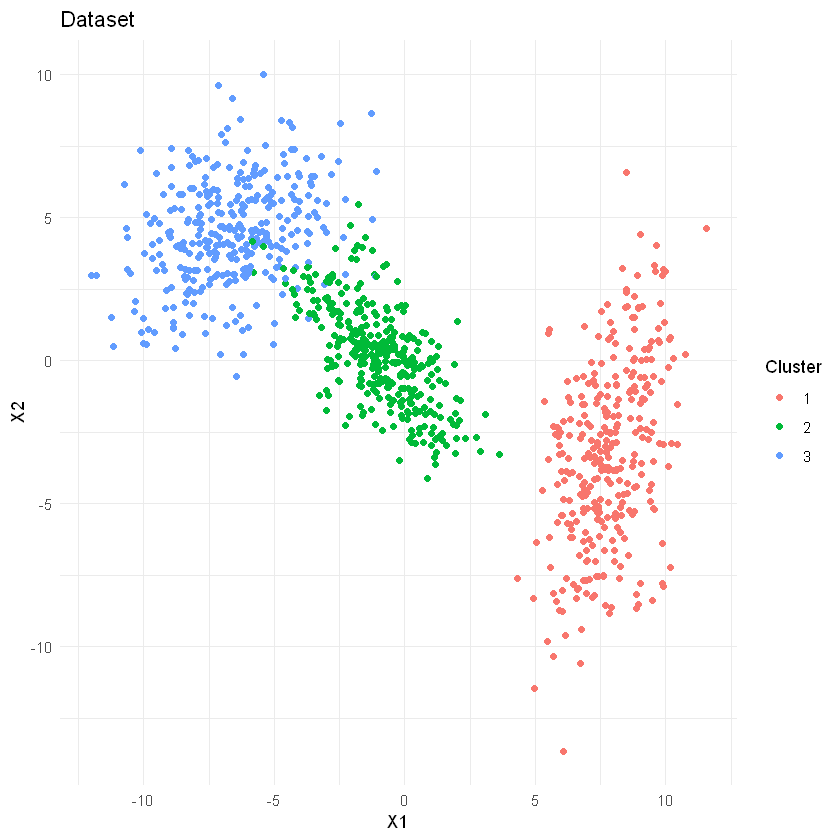

In [8]:
# Visualize the data (with the real labels)
ggplot(data=data, aes(x=X1, y=X2, color=factor(K))) + geom_point() +
    scale_color_discrete(guide = guide_legend(title = "Cluster")) + 
    ggtitle ('Dataset') + theme_minimal()

## Soft EM for GMM
We generated our data previously, so we know the real cluster labels. However, we pretend we do not have the real lables. Let's implement Soft Expectation Maximization for our GMM. Again we use `.hat` name convention to differentiate the real and estimated values. 

Let's set the parameters and then perform the initializations.

In [9]:
# Setting the parameters:
eta.max <- 100      # maximum number of iterations
epsilon <- 0.01     # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456) # save the random seed to make the results reproducible
Phi.hat <- 1/K                          # assume all clusters have the same size (we will update this later on)
Nk.hat <- matrix(N/K,nrow = K)          # refer to the above line!
Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly  choose K samples as cluster means (any better idea?)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) # create empty covariance matrices (we will fill them)
post <- matrix(,nrow=N, ncol=K)        # empty posterior matrix (the membership estimates will be stored here)

### for each cluster k:
for (k in 1:K){
    #### initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix
}

In [10]:
# print(Nk.hat)
# print(Mu.hat)
# print(Sigma.hat)

The following is the main loop of EM algorithm. In this loop, we iteratively take **E** and **M** steps until the termination criterion is met.

In [11]:
# matrix(Sigma.hat[k,], ncol=D)
# Mu.hat[k,]
# head(X)
# Nk.hat[k]
# head(dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k])

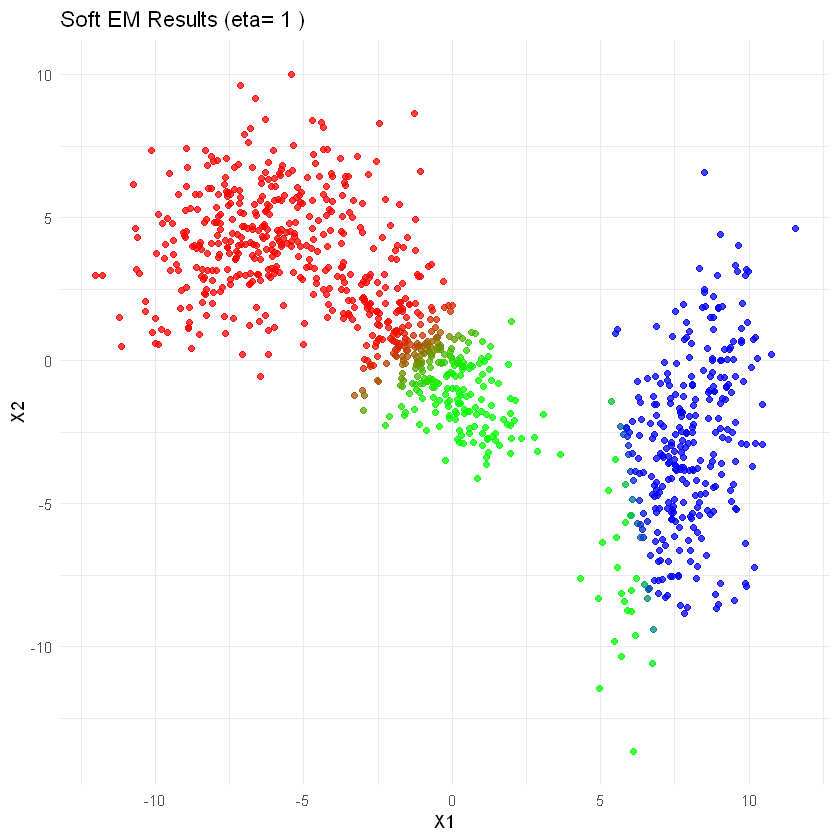

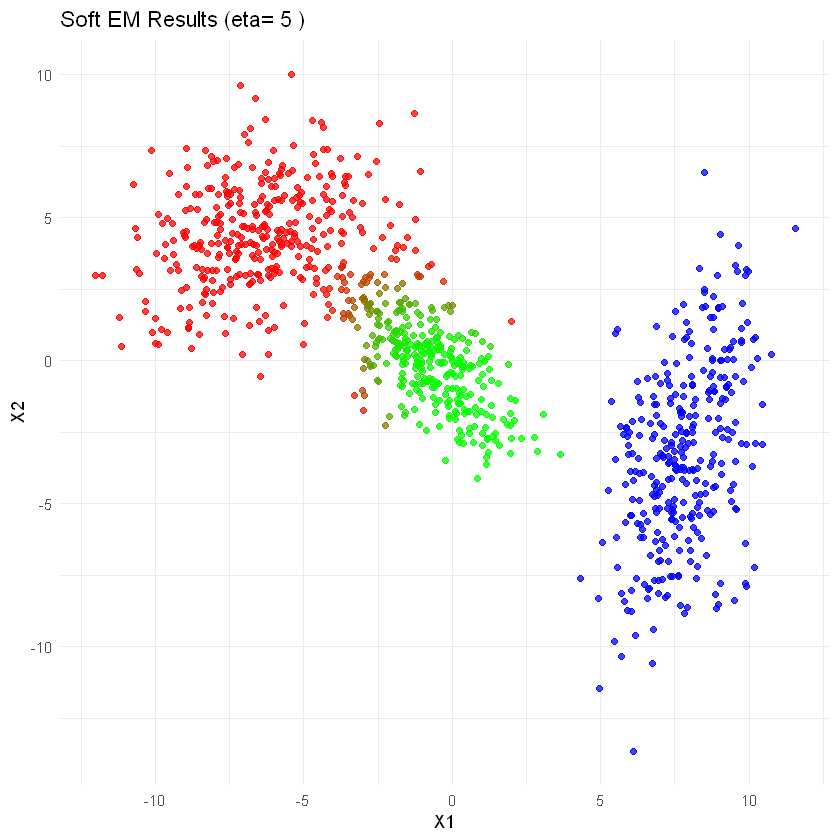

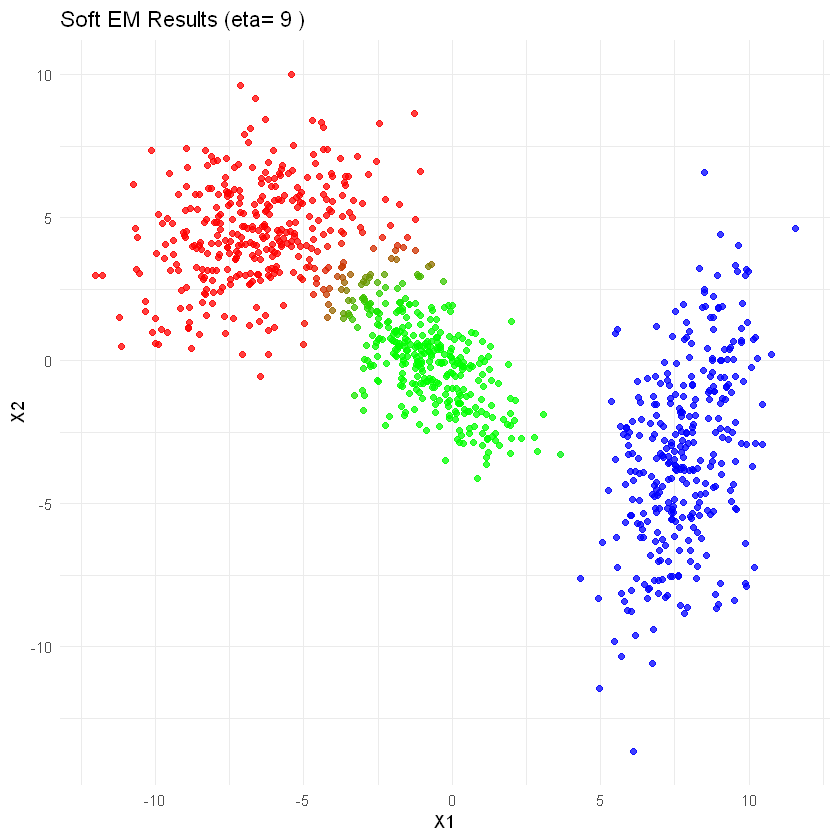

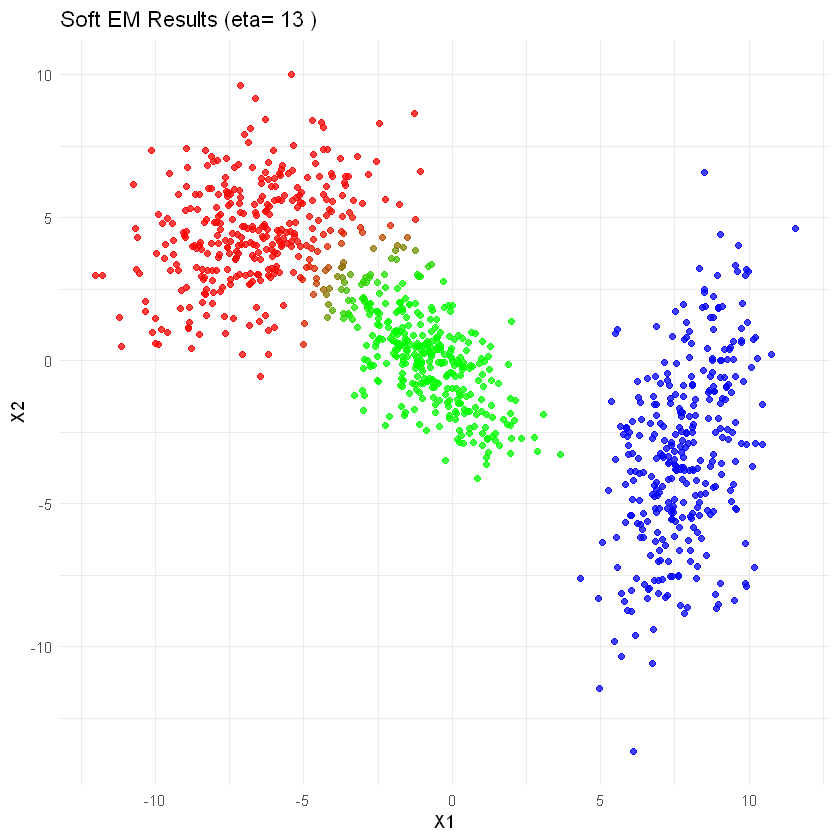

maximum number of iterations: 21 


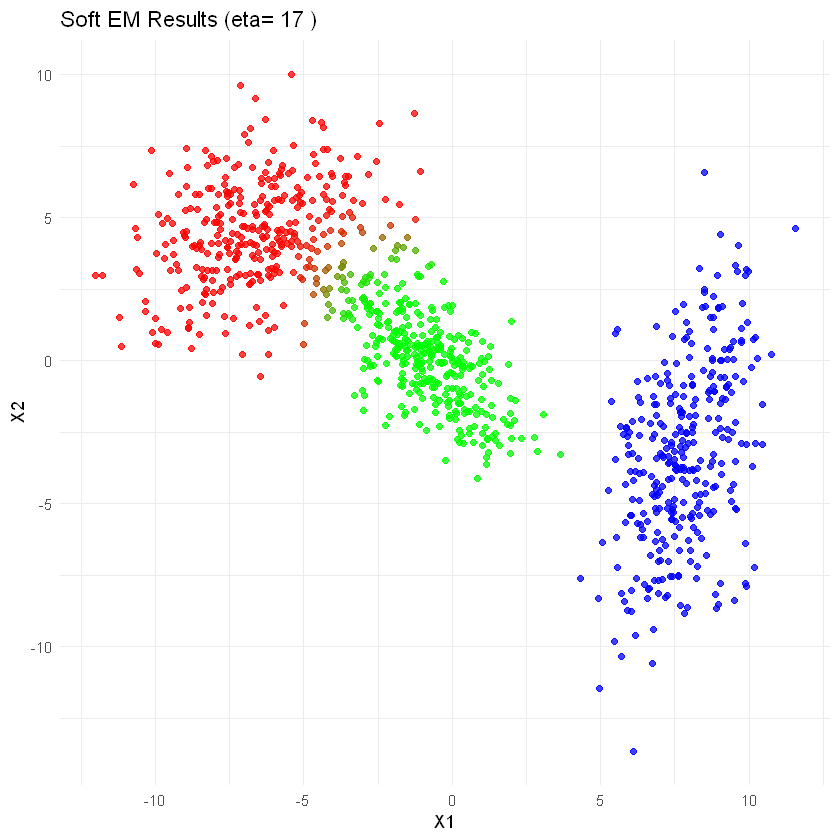

In [12]:
# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means
while (!terminate){
    
    # E step:    
    for (k in 1:K){
        ## calculate the posterior (for every data point) based on the estimated means,covariance and cluster size:
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
    }
    post <- post/rowSums(post) # normalization (to make sure post(k) is in [0,1] and sum(post)=1)

    # M step:
    for (k in 1:K){
        ## recalculate the estimations:
        Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
        Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        Sigma.hat[k,] <- (t(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))%*%
                          (post[,k]*(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))))/Nk.hat[k] # new covariance
    
    }

    if (eta %% 4 ==1) {
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Soft EM Results (eta=', eta, ')')) + theme_minimal())
        }
    
    # increase the epoch counter
    eta <- eta+1
    
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat

}
# That's it! Let see how many iterations we had:
cat('maximum number of iterations:',eta,'\n')

**Note:** The color code of the above figure(s) can be very different than the plot we draw using the real labels. This happens because the order of the estimated culsters may not be the same as the real order of the clusters.

As we observe in the plot(s), the intensity of the color of a particular point indicates the probability of that point being from the cluster which that color associated with. As a result, we see points with mixing colors (this is specific to soft assignment).

## Discussions
1- We built a GMM using soft EM and visualized it. Other than visualization, one can compare the real (generative) and estimated parameters to validate the discovered clusters. Perform this comparison for mean, covariance and effective number of points in each clusters, then discuss your findings. 
Note that the order of clusters, and hence their means, covariances, etc., may vary as EM has no idea about the real order of the clusters in the generation process. To make it easier to compare these values, you can sort them before comparing them.


## Solution

We will align with the order of the original clusters.  Descending X1 will provide (true) class 1 at the top, 2, next and 3 last

True => data<br>
Estimated => c(X, max(post))

In [13]:
data.orig <- data
str(data.orig)

'data.frame':	1000 obs. of  3 variables:
 $ K : int  2 1 1 3 3 1 3 2 3 1 ...
 $ X1: num  -2.5 6.24 9.3 -8.26 -8.05 ...
 $ X2: num  -0.717 -5.683 -0.813 1.57 2.384 ...


In [14]:
head(post)

7.071749e-04,9.992928e-01,1.800346e-19
7.046036e-22,9.350803e-05,9.999065e-01
6.866924e-20,3.407835e-15,1.000000e+00
9.999991e-01,8.991844e-07,6.973638e-48
9.999928e-01,7.189589e-06,6.130375e-48
3.873827e-19,3.800561e-10,1.000000e+00


In [15]:
#REF: https://stackoverflow.com/questions/17735859/for-each-row-return-the-column-name-of-the-largest-value
post.max <- colnames(data.frame(K=post))[max.col(data.frame(K=post),ties.method="first")]
#REF: https://stackoverflow.com/questions/21283148/substring-of-all-data-frame-elements
post.max <- data.frame(K=as.integer(substring(post.max, 3, 4)))
post.max$K = -post.max$K + 4
data.est <- cbind(K=post.max, X)
str(data.est)

'data.frame':	1000 obs. of  3 variables:
 $ K : num  2 1 1 3 3 1 3 2 3 1 ...
 $ X1: num  -2.5 6.24 9.3 -8.26 -8.05 ...
 $ X2: num  -0.717 -5.683 -0.813 1.57 2.384 ...


In [16]:
aggregate(data.orig[, 1], list(data.orig$K), length)
aggregate(data.est[, 1], list(data.est$K), length)

Group.1,x
1,322
2,349
3,329


Group.1,x
1,322
2,345
3,333


In [17]:
aggregate(data.orig[, -1], list(data.orig$K), mean)
aggregate(data.est[, -1], list(data.est$K), mean)

Group.1,X1,X2
1,7.8020284,-3.269284
2,-0.9770432,0.200809
3,-6.6516950,4.468487


Group.1,X1,X2
1,7.8020284,-3.2692839
2,-0.9238477,0.1415285
3,-6.6386435,4.4786401


In [18]:
#REF: https://stackoverflow.com/questions/21655270/covariance-matrix-by-group
cov.list.orig <- lapply(unique(data.orig$K),
                        function(x)cov(data.orig[data.orig$K==x,-1], use="na.or.complete"))
cov.list.est <- lapply(unique(data.est$K),
                        function(x)cov(data.orig[data.est$K==x,-1], use="na.or.complete"))

In [19]:
for (k in 1:3) {
    print(paste("Group ", k))
    print(cov.list.orig[k])
    print(cov.list.est[k])
    }                       

[1] "Group  1"
[[1]]
          X1        X2
X1  2.529770 -1.854119
X2 -1.854119  3.070227

[[1]]
          X1        X2
X1  2.305150 -1.668853
X2 -1.668853  2.829231

[1] "Group  2"
[[1]]
         X1        X2
X1 1.622013  1.782297
X2 1.782297 10.350218

[[1]]
         X1        X2
X1 1.622013  1.782297
X2 1.782297 10.350218

[1] "Group  3"
[[1]]
         X1       X2
X1 4.022629 1.123647
X2 1.123647 3.369556

[[1]]
         X1       X2
X1 3.994869 1.192653
X2 1.192653 3.305544



## Hard EM for GMM
In the above experiments, we implemented Soft EM. Now, we modify the code and develop a Hard EM for our GMM. Recal that in hard EM, $\gamma(z_{nk})$ only takes binary values as a data point either is a member of a cluster or not. To spot the difference between hard and soft EM, refer to the lines that are marked by `# hard assignments`.

In [ ]:
# Setting the parameters:
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.01  # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456) # save the random seed to make the results reproducble
Phi.hat <- 1/K                          # assume all clusters have the same size (we will update this later on)
Nk.hat <- matrix(N/K,nrow = K)          # refer to the above line!
Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly  choose K samples as cluster means (any better idea?)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) # create empty covariance matrices (we will fill them)
post <- matrix(,nrow=N, ncol=K)        # empty posterior matrix (the membership estimates will be stored here)

### for each cluster k:
for (k in 1:K){
    #### initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix
}

# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means

# Main Loop
while (!terminate){

    # E step:   
    for (k in 1:K){
        ## calculate the posterior based on the estimated means,covariance and cluster size:
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
    }
    
    # hard assignments:
    max.prob <- post==apply(post, 1, max) # for each point find the cluster with the maximum (estimated) probability
    post[max.prob] <- 1 # assign each point to the cluster with the highest probability
    post[!max.prob] <- 0 # remove points from clusters with lower probabilites


    # M step:
    for (k in 1:K){
        ## recalculate the estimations:
        Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
        Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        Sigma.hat[k,] <- (t(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))%*%
                          (post[,k]*(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))))/Nk.hat[k] # new covariance
    
    }
    
    # visualization
    if (eta %% 10 == 1){
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Hard EM (eta=', eta,')')) + theme_minimal())
        line <- readline()
    }
    par(new=FALSE)
    # increase the epoch counter
    eta <- eta+1
    
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat
}
# That's it! Let see how many iterations we had:
cat('maximum number of itterations:',eta,'\n')

In contrast with soft assignments, here each point only assigned to one cluster. Therefore, we do not see the any point with mixed colors.

## Discussions

### Initialization Effect
In the above experiments, we used a simple but reasonably good initialization. Try some other initializations, repeat the experiments and study the results. For example, you can change

`Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly choose K samples as cluster means`

to 

`Mu.hat <- matrix(0, nrow = K, ncol = D) # initialize all cluster means to the origin`

or

`Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix`

to 

`Sigma.hat[k,] <- genPositiveDefMat(D)$Sigma[1:D^2] # initialize with random covariance matrix`

### Kmeans vs. GMM
Discuss the followings:
* What are the main differences between Kmeans clustering and (hard) GMM? Explain the assumptions behind each one of them, as well as their limitaitons and strength (**Hint:** Think about the covariance matrix!).
* How one can combine Kmeans and GMM to have the bests of both worlds (**Hint:** Think about GMM initialization)?